# Packages and Utilities

In [486]:
import pandas as pd
import numpy as np
import torch
import time
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.distributions import Normal, Uniform
import os, warnings
from scipy.special import psi, gamma
from scipy.misc import derivative
import tqdm
import pickle as pkl

## Data Loading Utilities

In [156]:
# Data Loader 
class DataLoader:
    def __init__(self, E_max, which_data):
        """
        This class will read in 3He-alpha scattering data from the Som and Barnard
        datasets.

        Arguments:
        ----------
        E_max : float
        Determines the maximum energy of the data to consider.

        which_data : string
        Determines which data to look at
        """
        
        ##############################################################################
                    # Set the initial constants and useful variables
        ##############################################################################
        # Set the beam and target parameters
        self.Zb = 2 # Charge number
        self.Zt = 2 # Charge number
        self.mb = 2809.43 # MeV - 3He
        self.mt = 3728.42 # MeV - alpha
        self.mu = (self.mb * self.mt) / (self.mb + self.mt) # Reduced mass

        # Set useful constants and variables
        self.alpha = 1 / 137.036 # dimless (fine structure alpha_em)
        self.h_bar_c = 197.327 # MeV fm
        self.root_path = './'

        # Set which data and method we are going to use
        self.E_max = E_max
        self.which_data = which_data

        ##############################################################################
                                # Read in and set the data #
        ##############################################################################
        # Set up the list of paths to the data
        barnard_paths = [self.root_path + 'barnard_data/barnard5477.txt',
                        self.root_path + 'barnard_data/barnard6345.txt',
                        self.root_path + 'barnard_data/barnard7395.txt',
                        self.root_path + 'barnard_data/barnard9003.txt',
                        self.root_path + 'barnard_data/barnard10460.txt',
                        self.root_path + 'barnard_data/barnard11660.txt',
                        self.root_path + 'barnard_data/barnard12530.txt',
                        self.root_path + 'barnard_data/barnard14080.txt']

        som_paths = [self.root_path + 'SOM/som_cm_int1.npy',
                    self.root_path + 'SOM/som_cm_int2.npy',
                    self.root_path + 'SOM/som_cm_int3.npy']

        # Handle Barnard set first
        barnard_data_list = []
        for path in barnard_paths:
            barnard_data_list.append(np.loadtxt(path))

        # Handle Som set
        som_data_list = []
        l_som = [] # For Som normalization
        l_som_energies = []
        for path in som_paths:
            data_set = np.load(path, allow_pickle = True)
            som_data_list.append(data_set)
            l_som_energies.append([data_set[i][:, 0][0] for i in range(len(data_set))])
            l_som.append([len(data_set[j]) for j in range(len(data_set))])

        # Convert the lists into arrays
        barnard_data = np.concatenate(barnard_data_list)
        som_data = np.array(som_data_list)
        self.l_som_energies = np.array(l_som_energies)
        self.l_som = np.array(l_som)

        # Set up variables for bounds on parameters (widths of prior)
        som_f_sigmas = np.array([0.064, 0.076, 0.098, 0.057, 0.045, 0.062,
                            0.041, 0.077, 0.063, 0.089])
        barnard_f_sigma = np.array([0.05])

        # Note: *** The Barnard data has lowest E at 2.439 MeV and the 
        # Som data has lowest E at 0.676 MeV ***
        # Truncate the data based on the energy cutoff
        if E_max != None:
            if E_max < 0.706:
                sys.stderr.write('No data exists with E < 0.706!')
                sys.exit(-1)
            else:
                # Barnard first
                # Pulls the indices where the energy is less than E_max
                barnard_indices = np.where(barnard_data[:, 1] <= E_max)
                # Only pulls the correct indices
                barnard_data = barnard_data[barnard_indices]
                # Som next
                # Pulls the indices where the energy is less than E_max for each interaction region
                som_indices = np.array([np.where(int_region_energy <= E_max) for int_region_energy in self.l_som_energies])
                # Selects the correct indices from before and concatenates them
                som_data = np.concatenate([som_data_list[i][som_indices[i]] for i in range(0, len(l_som))])
                # Pulls the correct number of data points for each energy
                self.l_som = np.array(np.concatenate([self.l_som[i][som_indices[i]] for i in range(0, len(self.l_som))]))
                # Select all the som_f_sigmas we need 
                som_f_sigmas = som_f_sigmas[:self.l_som.shape[1]]

        # Convert Som data to an array
        som_data = np.concatenate(np.concatenate(som_data))

        # Som has the data formated by [E, theta, cs, err] but Barnard has [theta, E, cs, err]
        # so I need to standardize this. I will match the Barnard convention
        temp_som = som_data.copy()
        som_data = np.column_stack([temp_som[:, 1], temp_som[:, 0], temp_som[:, 2], temp_som[:, 3]])

        # Now select which data to use
        if self.which_data == 'both':
            self.data = np.concatenate([barnard_data, som_data])
            self.f_sigmas = np.concatenate([som_f_sigmas, barnard_f_sigma])
            self.barnard_Elab = barnard_data[:, 1] # For normalization purposes
        elif self.which_data == 'som':
            self.data = som_data
            self.f_sigmas = np.concatenate([som_f_sigmas])
        elif self.which_data == 'barnard':
            self.data = barnard_data
            self.f_sigmas = np.concatenate([barnard_f_sigma])
            self.barnard_Elab = barnard_data[:, 1] # For normalization purposes
        else:
            sys.stderr.write('Choose a \'which_data\': both, som, barnard...')
            sys.exit(-1)

        # We can unpackage the data into it's different components
        self.theta_cs = self.data[:, 0]
        self.Elab_cs = self.data[:, 1]
        self.cs_data = self.data[:, 2] # these are experimental observations (the y's)
        self.err_cs = self.data[:, 3] # these are standard deviations to be used to construct likelihood matrix
        
        self.f_mus = np.ones(self.f_sigmas.shape[0])
        self.f_bounds = np.array([[0, 2] for i in self.f_sigmas])

## PyTorch utilities

### MF - gaussian priors

In [394]:
class MCElboMF(torch.nn.Module):
    def __init__(self, nMC, x_dim, param_dim, f_dim, err_cs, Elab_cs, f_sigmas,
                 recompute_values = True, which_data = "both", barnard_Elab = None, l_som = None):
        """ MCElbo is a child of torch.nn.Module class that implements the model likelihood and forward function for the VI
            approximation
            
            nMc: Number of samples for MC approximation of ELBO (typically 5 - 10)
            x_dim: Dimension of known experimental inputs (for example Z and N)
            param_dim: Dimension of calibration parameters
            n: Sample size (this is a bit unnecesarily, but it skips one step in ELBO approximation)
        """
        super(MCElboMF, self).__init__()
        self.l_som = l_som
        self.barnard_Elab = barnard_Elab
        self.which_data = which_data
        self.root_path = './'
        self.err_cs = err_cs
        self.Elab_cs = Elab_cs
        self.n = len(err_cs)
    
        
        self.nMC = nMC
        self.x_dim = x_dim
        self.param_dim = param_dim #bit redundant to have both
        self.erp_dim = param_dim
        self.f_dim = f_dim
        self.softplus = torch.nn.Softplus() # transformation of the input x \in R tolog(1+exp(x)) (avoids constrained opt.)
         
        ####### VI inits ######    
        
        ### Prior distributions (assumed independent gaussian)
        
        gauss_prior_params = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
        f_mus = np.ones(self.f_dim)
        
        self.prior_theta_m = torch.tensor(np.concatenate([gauss_prior_params[:,0],f_mus]).reshape(1,self.param_dim + self.f_dim))
        self.prior_theta_s = torch.tensor(np.concatenate([gauss_prior_params[:,1],f_sigmas]).reshape(1,self.param_dim + self.f_dim))
        
        ### Variational parameters for the mean-field (fully factorized) variational posterior
        self.q_theta_m = torch.nn.Parameter(self.prior_theta_m.detach().clone()) # innitial values
        self.q_theta_s = torch.nn.Parameter(torch.expm1(self.prior_theta_s.detach().clone()).log())
        
        ### Current parameter state place holder
        self.params = self.prior_theta_m.detach().clone()
        
        # If likelihood is gaussian parametrized with precision (fixed for now)
        #self.precision = torch.FloatTensor((1))
        #self.precision.data.fill_(1/ (2.97 ** 2))
        
        # If likelihood is gaussian parametrized with std (fixed for now)
        #self.s = torch.FloatTensor((1))
        #self.s.data.fill_(1/ (2.97 ** 2))
        
        
        
        #########################################
        ############ Scatering inits #############
        ##########################################
        
         # # # Do statistics stuff # # #
        cov_expt_matrix = np.diag(self.err_cs**2)
        cov_matrix = cov_expt_matrix # + cov_theory_matrix
        ####
        
        self.Zb = 2 # Charge number
        self.Zt = 2 # Charge number
        self.mb = 2809.43 # MeV - 3He
        self.mt = 3728.42 # MeV - alpha
        self.mu = (self.mb * self.mt) / (self.mb + self.mt) # Reduced mass

        # Set useful constants and variables
        self.alpha = 1 / 137.036 # dimless (fine structure alpha_em)
        self.h_bar_c = 197.327 # MeV fm
        
        ##############################################################################
                    # Define the 'utility' functions as lambda functions #
        ##############################################################################
        
                # Square root to handle negative values
        self.sqrt = lambda x: np.sqrt(x) if x >= 0 else 1.0j * np.sqrt(np.abs(x))
        self.sqrt = np.vectorize(self.sqrt)

        # Cotangent to handle arguments in degrees
        self.cot = lambda theta_deg: (np.cos(theta_deg * (np.pi / 180)) /
                        np.sin(theta_deg * (np.pi / 180)))

        # Energy from lab frame to CM frame
        self.ECM = lambda Elab: ((2 * self.mt) / (self.mt + self.mb +
                        self.sqrt(((self.mt + self.mb)**2) +
                        2 * self.mt * Elab))) * Elab  #MeV
        
        # Energy from CM frame to lab frame
        self.ELAB = lambda Ecm: ((Ecm + (2 * (self.mt + self.mb))) /
                        (2.0 * self.mt)) * Ecm  #MeV 

        # Obtain kc as a function of Elab
        self.kc = lambda Elab: self.Zb * self.Zt * self.alpha * (
                        (self.mu + self.ECM(Elab)) / self.h_bar_c)  # fm^-1
        
        # Obtain k as a function of Elab
        self.k = lambda Elab: (1 / self.h_bar_c) * self.sqrt(
                        ((self.mu + self.ECM(Elab))**2) - self.mu**2)
        
                # Obtain eta as a function of Elab
        self.eta = lambda Elab: self.kc(Elab) / self.k(Elab)

        # Obtain H as a function of Elab
        self.H = lambda Elab: ((psi((1.j) * self.eta(Elab))) +
                            (1 / (2.j * self.eta(Elab))) -
                            np.log(1.j * self.eta(Elab)))
        
         # Define h as the real part of H as a function of Elab
        self.h = lambda Elab: self.H(Elab).real

        # Obtain C0_2 as a function of Elab
        self.C0_2 = lambda Elab: (2 * np.pi * self.eta(Elab)) / (
                            np.exp(2 * np.pi * self.eta(Elab)) - 1)
        
               # Obtain C1_2 as a function of Elab
        self.C1_2 = lambda Elab: (1 / 9) * (1 + self.eta(Elab)**2) * self.C0_2(Elab)

        # Obtain C2_2 as a function of Elab
        self.C2_2 = lambda Elab: (1 / 100) * (4 + self.eta(Elab)**2) * self.C1_2(Elab)

        # Obtain C3_2 as a function of Elab
        self.C3_2 = lambda Elab: (1 / 441) * (9 + self.eta(Elab)**2) * self.C2_2(Elab)

        # Derivative of H with respect to eta
        self.H_prime_eta = lambda eta: derivative(lambda x: (psi(1.j * x) + 1 / (2 * 1.j * x) - np.log(1.j * x)), eta, dx = 1e-10)


        # # # Save / Read in various files for values # # #
        if recompute_values:
            # Save files and then immediately read them back in
            save_k = np.savetxt('kvalue_cs.txt', self.k(self.Elab_cs), delimiter = ',')
            self.kvalue_cs = torch.tensor(np.loadtxt(self.root_path + 'kvalue_cs.txt'))
            save_kc = np.savetxt('kcvalue_cs.txt', self.kc(self.Elab_cs), delimiter = ',')
            self.kcvalue_cs = torch.tensor(np.loadtxt(self.root_path + 'kcvalue_cs.txt'))
            save_eta = np.savetxt('etavalue_cs.txt', self.eta(self.Elab_cs), delimiter = ',')
            self.etavalue_cs = torch.tensor(np.loadtxt(self.root_path + 'etavalue_cs.txt'))
            save_H_real = np.savetxt('Hvalue_cs_real.txt', np.real(self.H(self.Elab_cs)), delimiter = ',')
            self.Hvalue_cs_real = torch.tensor(np.loadtxt(self.root_path + 'Hvalue_cs_real.txt'))
            save_H_imag = np.savetxt('Hvalue_cs_imag.txt', np.imag(self.H(self.Elab_cs)), delimiter = ',')
            self.Hvalue_cs_imag = torch.tensor(np.loadtxt(self.root_path + 'Hvalue_cs_imag.txt'))
            self.Hvalue_cs = self.Hvalue_cs_real + 1.j * self.Hvalue_cs_imag
            save_C0_2 = np.savetxt('C0_2value_cs.txt', self.C0_2(self.Elab_cs), delimiter = ',')
            self.C0_2value_cs = torch.tensor(np.loadtxt(self.root_path + 'C0_2value_cs.txt'))
            save_C1_2 = np.savetxt('C1_2value_cs.txt', self.C1_2(self.Elab_cs), delimiter = ',')
            self.C1_2value_cs = torch.tensor(np.loadtxt(self.root_path + 'C1_2value_cs.txt'))
            #save_cs_LO = np.savetxt('cs_LO_values.txt', self.cs_LO(), delimiter = ',')
            #self.cs_LO_values = np.loadtxt(self.root_path + 'cs_LO_values.txt')
            save_inv_cov = np.savetxt('inv_cov_matrix.txt', (np.linalg.inv(cov_matrix)).flatten(), delimiter = ',')
            self.inv_cov_matrix = torch.tensor((np.loadtxt('inv_cov_matrix.txt')).reshape((self.n, self.n)))
            #save_cov_theory = np.savetxt('cov_theory_matrix.txt', self.cov_theory().flatten(), delimiter = ',')
            #self.cov_theory_matrix = (np.loadtxt('cov_theory_matrix.txt')).reshape((self.n, self.n))
            self.Q_rest = torch.tensor(np.sum(np.log(1.0 / np.sqrt(2.0 * np.pi * np.diag(cov_matrix)))))
        else:
            # Just read in the files
            self.kvalue_cs = torch.tensor(np.loadtxt(self.root_path + 'kvalue_cs.txt'))
            self.kcvalue_cs = torch.tensor(np.loadtxt(self.root_path + 'kcvalue_cs.txt'))
            self.etavalue_cs = torch.tensor(np.loadtxt(self.root_path + 'etavalue_cs.txt'))
            self.Hvalue_cs_real = torch.tensor(np.loadtxt(self.root_path + 'Hvalue_cs_real.txt'))
            self.Hvalue_cs_imag = torch.tensor(np.loadtxt(self.root_path + 'Hvalue_cs_imag.txt'))
            self.Hvalue_cs = self.Hvalue_cs_real + 1.j * self.Hvalue_cs_imag
            self.C0_2value_cs = torch.tensor(np.loadtxt(self.root_path + 'C0_2value_cs.txt'))
            self.C1_2value_cs = torch.tensor(np.loadtxt(self.root_path + 'C1_2value_cs.txt'))
            #self.cs_LO_values = np.loadtxt(self.root_path + 'cs_LO_values.txt')
            self.inv_cov_matrix = torch.tensor((np.loadtxt('inv_cov_matrix.txt')).reshape((self.n, self.n)))
            #self.cov_theory_matrix = (np.loadtxt('cov_theory_matrix.txt')).reshape((len(self.cs_data), len(self.cs_data)))
            self.Q_rest = torch.tensor(np.sum(np.log(1.0 / np.sqrt(2.0 * np.pi * np.diag(cov_matrix)))))
            
        ##############################################################################
                            # Define the binding energy of the 7Be #
        ##############################################################################
        # Binding energy of 7Be in 3/2+ and 1/2- channels
        E_plus = torch.tensor(1.5866) # MeV
        E_minus = torch.tensor(1.1575) # MeV

        # Binding momenta of the 3/2+ and 1/2- channels
        self.gamma1_plus = np.sqrt(2 * self.mu * E_plus) / self.h_bar_c
        self.gamma1_minus = np.sqrt(2 * self.mu * E_minus) / self.h_bar_c

        # Get the kc's
        self.kc_plus = (self.Zb * self.Zt * self.alpha * (self.mu - E_plus)) / self.h_bar_c
        self.kc_minus = (self.Zb * self.Zt * self.alpha * (self.mu - E_minus)) / self.h_bar_c

        # Define the Sommerfeld parameters
        self.eta_B_plus = self.kc_plus / self.gamma1_plus
        self.eta_B_minus = self.kc_minus / self.gamma1_minus

        # Define the H's
        self.H_plus = psi(self.eta_B_plus) + (1 / (2 * self.eta_B_plus)) - np.log(self.eta_B_plus)
        self.H_minus = psi(self.eta_B_minus) + (1 / (2 * self.eta_B_minus)) - np.log(self.eta_B_minus)
        self.H_prime_plus = self.H_prime_eta(-self.eta_B_plus * (1.j))
        self.H_prime_minus = self.H_prime_eta(-self.eta_B_minus * (1.j))
        
    def __str__(self):
        return f"VI ELBO for a model with {self.param_dim} calibration parameters, {self.x_dim} dimensional input. "\
                + f"{self.nMC} MC samples are used for MC approximation."
        
    def cs_theory_bsc_in_C(self, inputs, params):
        """
        # inputs are teta_cs
        This method utilizes the existence of a bound state and also the asymptotic normalization coefficients
        to compute the theoretical cross section at the energies and angles where we have data.

        NOTE: C1+/- is really (C1+/-)^2 since we are sampling C1 squared
        """
        # Extract the parameters from params
        A0, r0, C1plus, P1plus, C1minus, P1minus = params # this is first time we get params

        # Convert theta to radians
        theta_rad = inputs * (np.pi / 180)

        # Compute r1plus and r1minus based on the relation
        r1plus = torch.real(-(2 * self.gamma1_plus**2 * torch.exp(torch.special.gammaln(2 + self.eta_B_plus))**2) / C1plus + (P1plus * self.gamma1_plus**2) + (
            4 * self.kc_plus * self.H_plus) + (
            2.j * self.kc_plus * self.eta_B_plus * (1 - self.eta_B_plus**2) * self.H_prime_plus))
        r1minus = torch.real(-(2 * self.gamma1_minus**2 * torch.exp(torch.special.gammaln(2 + self.eta_B_minus))**2) / C1minus + (P1minus * self.gamma1_minus**2) + (
            4 * self.kc_minus * self.H_minus) + (
            2.j * self.kc_minus * self.eta_B_minus * (1 - self.eta_B_minus**2) * self.H_prime_minus))

        # Compute A1plus and A1minus based on the bound state condition
        A1plus = - (r1plus * self.gamma1_plus**2) / 2 + (0.25 * P1plus * self.gamma1_plus**4) + (
            2 * self.kc_plus * (self.gamma1_plus**2 - self.kc_plus**2)) * self.H_plus
        A1minus = - (r1minus * self.gamma1_minus**2) / 2 + (0.25 * P1minus * self.gamma1_minus**4) + (
            2 * self.kc_minus * (self.gamma1_minus**2 - self.kc_minus**2)) * self.H_minus

        # Set up the necessary Legendre polynomials
        P_1 = torch.cos(theta_rad)

        # Phase terms
        alpha_1 = torch.arcsin((self.etavalue_cs / torch.sqrt(1 + torch.square(self.etavalue_cs))))
        phase_1 = torch.cos(2 * alpha_1) + (1.j) * torch.sin(2 * alpha_1)

        K_0 = (1 / (2 * self.kcvalue_cs)) * (-A0 + 0.5 * r0 * self.kvalue_cs**2)
        K_1_plus = (1 / (2 * self.kcvalue_cs**3)) * (-A1plus + 
                0.5 * r1plus * self.kvalue_cs**2 + 
                    0.25 * P1plus * self.kvalue_cs**4)
        K_1_minus = (1 / (2 * self.kcvalue_cs**3)) * (-A1minus + 
                0.5 * r1minus * self.kvalue_cs**2 + 
                    0.25 * P1minus * self.kvalue_cs**4)
        
        ERE_0 = (2 * self.kcvalue_cs * (K_0 - self.Hvalue_cs)) / self.C0_2value_cs
        ERE_1_plus = (2 * self.kcvalue_cs / (9 * self.C1_2value_cs)) * (
            self.kcvalue_cs**2 * K_1_plus - 
                (self.kcvalue_cs**2 + self.kvalue_cs**2) * self.Hvalue_cs)
        ERE_1_minus = (2 * self.kcvalue_cs / (9 * self.C1_2value_cs)) * (
            self.kcvalue_cs**2 * K_1_minus - 
                (self.kcvalue_cs**2 + self.kvalue_cs**2) * self.Hvalue_cs)

        # Compute the amplitude of each of the components
        # Rutherford
        f_r = (-self.etavalue_cs / (2 * self.kvalue_cs)) * (
            1 / np.sin(theta_rad / 2)**2)**(1 + (1.j) * self.etavalue_cs)
        
        # Coulomb
        f_c = f_r + (1 / ERE_0) + (self.kvalue_cs**2 * phase_1 * P_1) * (
            (2 / ERE_1_plus) + (1 / ERE_1_minus))

        # Interaction
        f_i = self.kvalue_cs**2 * phase_1 * torch.sin(theta_rad) * (
            (1 / ERE_1_minus) - (1 / ERE_1_plus))

        sigma = 10 * (torch.abs(f_c)**2 + torch.abs(f_i)**2)
        sigma_R = 10 * torch.abs(f_r)**2
        sigma_ratio = sigma / sigma_R
        return sigma_ratio    
    
    def chi_squared(self, theory, expt, norm):
        """
        """
        #print(norm.shape, theory.shape, expt.shape)
        r = norm * theory - expt
        chi_2 = r @ self.inv_cov_matrix @ r
        return chi_2, r
    
    def log_likelihood(self, inputs, exp):
        """
        Determines the likelihood of a set of parameters given the data.
        """
        # Cast the parameters to an array
        #parameters = torch.tensor([2,2,3,4,5,6] + [1] * self.f_dim) # this will be changed to self.params
        parameters = self.params[0]

        # Unpack the erps and normalization parameters
        params = parameters[:self.erp_dim]
        params_f = parameters[self.erp_dim:]

        # If the parameters are within the bounds, compute the log likelihood
        if self.which_data == 'barnard':
            norm_barnard = params_f[-1].repeat(len(self.barnard_Elab))
            norm_som = torch.tensor([])
        if self.which_data == 'som':
            norm_barnard = torch.tensor([])
            norm_som = torch.tensor([])
            for l_int in self.l_som:
                norms = torch.cat([params_f[j].repeat(l_int[j]) for j in range(0, l_int.shape[0])])
                #norm_som.append(norms)
                norm_som = torch.cat([norm_som, norms])
            #norm_som = torch.cat(norm_som)
        if self.which_data == 'both':
            norm_barnard = params_f[-1].repeat( len(self.barnard_Elab))
            norm_som = torch.tensor([])
            for l_int in self.l_som:
                norms = torch.cat([params_f[j].repeat( l_int[j]) for j in range(0, l_int.shape[0])])
                #print(norms)
                norm_som = torch.cat([norm_som, norms])
            #norm_som = torch.cat(norm_som)

        # Set the normalizations, theory values, and the exp values
        norm = torch.cat([norm_som, norm_barnard])
        theory = self.cs_theory_bsc_in_C(inputs,  params)
        #theory = self.cs_theory(params)
        #experiment = self.cs_data
        experiment = exp

        # Compute the chi squared
        chi2 = self.chi_squared(theory, experiment, norm)[0]

        # Compute the likelihood
        log_L = -0.5 * chi2 + self.Q_rest
        return log_L
    
    def log_Normal(self, param, m, s):
        """Computes log likelihood of normal density
        Args:
            param: 1 X K dimensional tensor
            m: 1 X K dimensional mean tensor
            s: 1 X K dimensional std tensor
        """
        interm__ = ((param - m) / s).pow(2)
        log_prob = - len(param) * np.log(2 * np.pi) / 2 - torch.log(s).sum() - 0.5 * interm__.sum()
        return log_prob.reshape(1,1)
        
    def q_log(self):
        """Variational family log likelihood. Gaussian."""
        log_lkl = self.log_Normal(self.params, self.q_theta_m, self.softplus(self.q_theta_s))  
        return log_lkl
        
    def pri_log(self):
        """Prior distribution log likelohood. Gaussian"""
        log_lkl = self.log_Normal(self.params, self.prior_theta_m, self.prior_theta_s) 
        return log_lkl
    
    def generate_sample(self, n_var = 2):
        """Used for sampling from a variational family"""
        return Normal(0,1).sample((self.nMC,n_var,1))
    
    def sample_reparam_normal(self, param, m, s):
        """Reparametrization trick"""
        return param.mul(self.softplus(s.T)).add(m.T)
    
    #def data_likelihood(self, x, y):
    #    """Returns data gaussian likelihood for one MC sample. Precision parametrization
    #    
    #        x: inputs (assumed to be n x x_dim tensor)
    #        y: experimental observations (assumed to be a row tensor of size n)
    #    """
    #    y_fit = y  #This is a placeholder, y_fit is the model fit 
    #    log_likelihood = (torch.log(self.precision) - np.log(2 * np.pi)) * 0.5 * self.n  - 0.5 * self.precision * torch.sum(torch.pow(y-y_fit, 2))    
    #    return log_likelihood
    
    def compute_elbo_loop(self, x, y):     
        
        z = self.generate_sample(n_var = self.param_dim + self.f_dim)
        theta = self.sample_reparam_normal(z, self.q_theta_m, self.q_theta_s)
       

        loss = torch.randn(1,1)
        loss.data.fill_(0.0)
        
        for i in range(self.nMC):
            self.params = theta[i].T
            
            q_likelihood = self.q_log()
            prior_likelihood = self.pri_log()
            data_likelihood = self.log_likelihood(x, y)
            loss += data_likelihood + prior_likelihood - q_likelihood
        return loss / self.nMC
    
    def ModelString(self):
        return f"theta mean: {self.q_theta_m} \n theta std {self.softplus(self.q_theta_s)}"

### Full - gaussian priors

In [557]:
class MCElboFG(torch.nn.Module):
    def __init__(self, nMC, x_dim, param_dim, f_dim, err_cs, Elab_cs, f_sigmas,
                 recompute_values = True, which_data = "both", barnard_Elab = None, l_som = None):
        """ MCElbo is a child of torch.nn.Module class that implements the model likelihood and forward function for the VI
            approximation
            
            nMc: Number of samples for MC approximation of ELBO (typically 5 - 10)
            x_dim: Dimension of known experimental inputs (for example Z and N)
            param_dim: Dimension of calibration parameters
            n: Sample size (this is a bit unnecesarily, but it skips one step in ELBO approximation)
        """
        super(MCElboFG, self).__init__()
        self.l_som = l_som
        self.barnard_Elab = barnard_Elab
        self.which_data = which_data
        self.root_path = './'
        self.err_cs = err_cs
        self.Elab_cs = Elab_cs
        self.n = len(err_cs)
        
        self.up_i = np.triu_indices(param_dim + f_dim, k =1)
        self.diag_i = (np.array(range(param_dim + f_dim)),np.array(range(param_dim + f_dim)))
        
        self.nMC = nMC
        self.x_dim = x_dim
        self.param_dim = param_dim #bit redundant to have both
        self.erp_dim = param_dim
        self.f_dim = f_dim
        self.softplus = torch.nn.Softplus() # transformation of the input x \in R tolog(1+exp(x)) (avoids constrained opt.)
         
        ####### VI inits ######    
        
        ### Prior distributions (assumed independent gaussian)
        
        #Bounds for truncated normals
        
        #Prior means and sds
        gauss_prior_params = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
        f_mus = np.ones(self.f_dim)
        
        self.prior_theta_m = torch.tensor(np.concatenate([gauss_prior_params[:,0],f_mus]).reshape(1,self.param_dim + self.f_dim))
        self.prior_theta_s = torch.tensor(np.concatenate([gauss_prior_params[:,1],f_sigmas]).reshape(1,self.param_dim + self.f_dim))
        
        ### Variational parameters for the mean-field (fully factorized) variational posterior
        self.q_theta_m = torch.nn.Parameter(self.prior_theta_m.detach().clone()) # innitial values
        self.q_theta_s = torch.nn.Parameter(torch.expm1(self.prior_theta_s.detach().clone()).log())
        self.q_theta_c = torch.nn.Parameter(torch.rand(1,  int((param_dim + f_dim) * (param_dim + f_dim + 1)/2 - (param_dim + f_dim)), dtype=torch.float64))  # corr_params
        
        ### Current parameter state place holder
        self.params = self.prior_theta_m.detach().clone()
        
        # If likelihood is gaussian parametrized with precision (fixed for now)
        #self.precision = torch.FloatTensor((1))
        #self.precision.data.fill_(1/ (2.97 ** 2))
        
        # If likelihood is gaussian parametrized with std (fixed for now)
        #self.s = torch.FloatTensor((1))
        #self.s.data.fill_(1/ (2.97 ** 2))
        
        
        
        #########################################
        ############ Scatering inits #############
        ##########################################
        
         # # # Do statistics stuff # # #
        cov_expt_matrix = np.diag(self.err_cs**2)
        cov_matrix = cov_expt_matrix # + cov_theory_matrix
        ####
        
        self.Zb = 2 # Charge number
        self.Zt = 2 # Charge number
        self.mb = 2809.43 # MeV - 3He
        self.mt = 3728.42 # MeV - alpha
        self.mu = (self.mb * self.mt) / (self.mb + self.mt) # Reduced mass

        # Set useful constants and variables
        self.alpha = 1 / 137.036 # dimless (fine structure alpha_em)
        self.h_bar_c = 197.327 # MeV fm
        
        ##############################################################################
                    # Define the 'utility' functions as lambda functions #
        ##############################################################################
        
                # Square root to handle negative values
        self.sqrt = lambda x: np.sqrt(x) if x >= 0 else 1.0j * np.sqrt(np.abs(x))
        self.sqrt = np.vectorize(self.sqrt)

        # Cotangent to handle arguments in degrees
        self.cot = lambda theta_deg: (np.cos(theta_deg * (np.pi / 180)) /
                        np.sin(theta_deg * (np.pi / 180)))

        # Energy from lab frame to CM frame
        self.ECM = lambda Elab: ((2 * self.mt) / (self.mt + self.mb +
                        self.sqrt(((self.mt + self.mb)**2) +
                        2 * self.mt * Elab))) * Elab  #MeV
        
        # Energy from CM frame to lab frame
        self.ELAB = lambda Ecm: ((Ecm + (2 * (self.mt + self.mb))) /
                        (2.0 * self.mt)) * Ecm  #MeV 

        # Obtain kc as a function of Elab
        self.kc = lambda Elab: self.Zb * self.Zt * self.alpha * (
                        (self.mu + self.ECM(Elab)) / self.h_bar_c)  # fm^-1
        
        # Obtain k as a function of Elab
        self.k = lambda Elab: (1 / self.h_bar_c) * self.sqrt(
                        ((self.mu + self.ECM(Elab))**2) - self.mu**2)
        
                # Obtain eta as a function of Elab
        self.eta = lambda Elab: self.kc(Elab) / self.k(Elab)

        # Obtain H as a function of Elab
        self.H = lambda Elab: ((psi((1.j) * self.eta(Elab))) +
                            (1 / (2.j * self.eta(Elab))) -
                            np.log(1.j * self.eta(Elab)))
        
         # Define h as the real part of H as a function of Elab
        self.h = lambda Elab: self.H(Elab).real

        # Obtain C0_2 as a function of Elab
        self.C0_2 = lambda Elab: (2 * np.pi * self.eta(Elab)) / (
                            np.exp(2 * np.pi * self.eta(Elab)) - 1)
        
               # Obtain C1_2 as a function of Elab
        self.C1_2 = lambda Elab: (1 / 9) * (1 + self.eta(Elab)**2) * self.C0_2(Elab)

        # Obtain C2_2 as a function of Elab
        self.C2_2 = lambda Elab: (1 / 100) * (4 + self.eta(Elab)**2) * self.C1_2(Elab)

        # Obtain C3_2 as a function of Elab
        self.C3_2 = lambda Elab: (1 / 441) * (9 + self.eta(Elab)**2) * self.C2_2(Elab)

        # Derivative of H with respect to eta
        self.H_prime_eta = lambda eta: derivative(lambda x: (psi(1.j * x) + 1 / (2 * 1.j * x) - np.log(1.j * x)), eta, dx = 1e-10)


        # # # Save / Read in various files for values # # #
        if recompute_values:
            # Save files and then immediately read them back in
            save_k = np.savetxt('kvalue_cs.txt', self.k(self.Elab_cs), delimiter = ',')
            self.kvalue_cs = torch.tensor(np.loadtxt(self.root_path + 'kvalue_cs.txt'))
            save_kc = np.savetxt('kcvalue_cs.txt', self.kc(self.Elab_cs), delimiter = ',')
            self.kcvalue_cs = torch.tensor(np.loadtxt(self.root_path + 'kcvalue_cs.txt'))
            save_eta = np.savetxt('etavalue_cs.txt', self.eta(self.Elab_cs), delimiter = ',')
            self.etavalue_cs = torch.tensor(np.loadtxt(self.root_path + 'etavalue_cs.txt'))
            save_H_real = np.savetxt('Hvalue_cs_real.txt', np.real(self.H(self.Elab_cs)), delimiter = ',')
            self.Hvalue_cs_real = torch.tensor(np.loadtxt(self.root_path + 'Hvalue_cs_real.txt'))
            save_H_imag = np.savetxt('Hvalue_cs_imag.txt', np.imag(self.H(self.Elab_cs)), delimiter = ',')
            self.Hvalue_cs_imag = torch.tensor(np.loadtxt(self.root_path + 'Hvalue_cs_imag.txt'))
            self.Hvalue_cs = self.Hvalue_cs_real + 1.j * self.Hvalue_cs_imag
            save_C0_2 = np.savetxt('C0_2value_cs.txt', self.C0_2(self.Elab_cs), delimiter = ',')
            self.C0_2value_cs = torch.tensor(np.loadtxt(self.root_path + 'C0_2value_cs.txt'))
            save_C1_2 = np.savetxt('C1_2value_cs.txt', self.C1_2(self.Elab_cs), delimiter = ',')
            self.C1_2value_cs = torch.tensor(np.loadtxt(self.root_path + 'C1_2value_cs.txt'))
            #save_cs_LO = np.savetxt('cs_LO_values.txt', self.cs_LO(), delimiter = ',')
            #self.cs_LO_values = np.loadtxt(self.root_path + 'cs_LO_values.txt')
            save_inv_cov = np.savetxt('inv_cov_matrix.txt', (np.linalg.inv(cov_matrix)).flatten(), delimiter = ',')
            self.inv_cov_matrix = torch.tensor((np.loadtxt('inv_cov_matrix.txt')).reshape((self.n, self.n)))
            #save_cov_theory = np.savetxt('cov_theory_matrix.txt', self.cov_theory().flatten(), delimiter = ',')
            #self.cov_theory_matrix = (np.loadtxt('cov_theory_matrix.txt')).reshape((self.n, self.n))
            self.Q_rest = torch.tensor(np.sum(np.log(1.0 / np.sqrt(2.0 * np.pi * np.diag(cov_matrix)))))
        else:
            # Just read in the files
            self.kvalue_cs = torch.tensor(np.loadtxt(self.root_path + 'kvalue_cs.txt'))
            self.kcvalue_cs = torch.tensor(np.loadtxt(self.root_path + 'kcvalue_cs.txt'))
            self.etavalue_cs = torch.tensor(np.loadtxt(self.root_path + 'etavalue_cs.txt'))
            self.Hvalue_cs_real = torch.tensor(np.loadtxt(self.root_path + 'Hvalue_cs_real.txt'))
            self.Hvalue_cs_imag = torch.tensor(np.loadtxt(self.root_path + 'Hvalue_cs_imag.txt'))
            self.Hvalue_cs = self.Hvalue_cs_real + 1.j * self.Hvalue_cs_imag
            self.C0_2value_cs = torch.tensor(np.loadtxt(self.root_path + 'C0_2value_cs.txt'))
            self.C1_2value_cs = torch.tensor(np.loadtxt(self.root_path + 'C1_2value_cs.txt'))
            #self.cs_LO_values = np.loadtxt(self.root_path + 'cs_LO_values.txt')
            self.inv_cov_matrix = torch.tensor((np.loadtxt('inv_cov_matrix.txt')).reshape((self.n, self.n)))
            #self.cov_theory_matrix = (np.loadtxt('cov_theory_matrix.txt')).reshape((len(self.cs_data), len(self.cs_data)))
            self.Q_rest = torch.tensor(np.sum(np.log(1.0 / np.sqrt(2.0 * np.pi * np.diag(cov_matrix)))))
            
        ##############################################################################
                            # Define the binding energy of the 7Be #
        ##############################################################################
        # Binding energy of 7Be in 3/2+ and 1/2- channels
        E_plus = torch.tensor(1.5866) # MeV
        E_minus = torch.tensor(1.1575) # MeV

        # Binding momenta of the 3/2+ and 1/2- channels
        self.gamma1_plus = np.sqrt(2 * self.mu * E_plus) / self.h_bar_c
        self.gamma1_minus = np.sqrt(2 * self.mu * E_minus) / self.h_bar_c

        # Get the kc's
        self.kc_plus = (self.Zb * self.Zt * self.alpha * (self.mu - E_plus)) / self.h_bar_c
        self.kc_minus = (self.Zb * self.Zt * self.alpha * (self.mu - E_minus)) / self.h_bar_c

        # Define the Sommerfeld parameters
        self.eta_B_plus = self.kc_plus / self.gamma1_plus
        self.eta_B_minus = self.kc_minus / self.gamma1_minus

        # Define the H's
        self.H_plus = psi(self.eta_B_plus) + (1 / (2 * self.eta_B_plus)) - np.log(self.eta_B_plus)
        self.H_minus = psi(self.eta_B_minus) + (1 / (2 * self.eta_B_minus)) - np.log(self.eta_B_minus)
        self.H_prime_plus = self.H_prime_eta(-self.eta_B_plus * (1.j))
        self.H_prime_minus = self.H_prime_eta(-self.eta_B_minus * (1.j))
        
    def __str__(self):
        return f"VI ELBO for a model with {self.param_dim} calibration parameters, {self.x_dim} dimensional input. "\
                + f"{self.nMC} MC samples are used for MC approximation."
        
    def cs_theory_bsc_in_C(self, inputs, params):
        """
        # inputs are teta_cs
        This method utilizes the existence of a bound state and also the asymptotic normalization coefficients
        to compute the theoretical cross section at the energies and angles where we have data.

        NOTE: C1+/- is really (C1+/-)^2 since we are sampling C1 squared
        """
        # Extract the parameters from params
        A0, r0, C1plus, P1plus, C1minus, P1minus = params # this is first time we get params

        # Convert theta to radians
        theta_rad = inputs * (np.pi / 180)

        # Compute r1plus and r1minus based on the relation
        r1plus = torch.real(-(2 * self.gamma1_plus**2 * torch.exp(torch.special.gammaln(2 + self.eta_B_plus))**2) / C1plus + (P1plus * self.gamma1_plus**2) + (
            4 * self.kc_plus * self.H_plus) + (
            2.j * self.kc_plus * self.eta_B_plus * (1 - self.eta_B_plus**2) * self.H_prime_plus))
        r1minus = torch.real(-(2 * self.gamma1_minus**2 * torch.exp(torch.special.gammaln(2 + self.eta_B_minus))**2) / C1minus + (P1minus * self.gamma1_minus**2) + (
            4 * self.kc_minus * self.H_minus) + (
            2.j * self.kc_minus * self.eta_B_minus * (1 - self.eta_B_minus**2) * self.H_prime_minus))

        # Compute A1plus and A1minus based on the bound state condition
        A1plus = - (r1plus * self.gamma1_plus**2) / 2 + (0.25 * P1plus * self.gamma1_plus**4) + (
            2 * self.kc_plus * (self.gamma1_plus**2 - self.kc_plus**2)) * self.H_plus
        A1minus = - (r1minus * self.gamma1_minus**2) / 2 + (0.25 * P1minus * self.gamma1_minus**4) + (
            2 * self.kc_minus * (self.gamma1_minus**2 - self.kc_minus**2)) * self.H_minus

        # Set up the necessary Legendre polynomials
        P_1 = torch.cos(theta_rad)

        # Phase terms
        alpha_1 = torch.arcsin((self.etavalue_cs / torch.sqrt(1 + torch.square(self.etavalue_cs))))
        phase_1 = torch.cos(2 * alpha_1) + (1.j) * torch.sin(2 * alpha_1)

        K_0 = (1 / (2 * self.kcvalue_cs)) * (-A0 + 0.5 * r0 * self.kvalue_cs**2)
        K_1_plus = (1 / (2 * self.kcvalue_cs**3)) * (-A1plus + 
                0.5 * r1plus * self.kvalue_cs**2 + 
                    0.25 * P1plus * self.kvalue_cs**4)
        K_1_minus = (1 / (2 * self.kcvalue_cs**3)) * (-A1minus + 
                0.5 * r1minus * self.kvalue_cs**2 + 
                    0.25 * P1minus * self.kvalue_cs**4)
        
        ERE_0 = (2 * self.kcvalue_cs * (K_0 - self.Hvalue_cs)) / self.C0_2value_cs
        ERE_1_plus = (2 * self.kcvalue_cs / (9 * self.C1_2value_cs)) * (
            self.kcvalue_cs**2 * K_1_plus - 
                (self.kcvalue_cs**2 + self.kvalue_cs**2) * self.Hvalue_cs)
        ERE_1_minus = (2 * self.kcvalue_cs / (9 * self.C1_2value_cs)) * (
            self.kcvalue_cs**2 * K_1_minus - 
                (self.kcvalue_cs**2 + self.kvalue_cs**2) * self.Hvalue_cs)

        # Compute the amplitude of each of the components
        # Rutherford
        f_r = (-self.etavalue_cs / (2 * self.kvalue_cs)) * (
            1 / np.sin(theta_rad / 2)**2)**(1 + (1.j) * self.etavalue_cs)
        
        # Coulomb
        f_c = f_r + (1 / ERE_0) + (self.kvalue_cs**2 * phase_1 * P_1) * (
            (2 / ERE_1_plus) + (1 / ERE_1_minus))

        # Interaction
        f_i = self.kvalue_cs**2 * phase_1 * torch.sin(theta_rad) * (
            (1 / ERE_1_minus) - (1 / ERE_1_plus))

        sigma = 10 * (torch.abs(f_c)**2 + torch.abs(f_i)**2)
        sigma_R = 10 * torch.abs(f_r)**2
        sigma_ratio = sigma / sigma_R
        return sigma_ratio    
    
    def cholesky_factor(self):
        U = torch.zeros((self.param_dim + self.f_dim ,self.param_dim + self.f_dim), dtype=torch.float64)
        U[self.up_i] = self.q_theta_c
        U[self.diag_i] = self.softplus(self.q_theta_s)
        return U.T
    
    def chi_squared(self, theory, expt, norm):
        """
        """
        #print(norm.shape, theory.shape, expt.shape)
        r = norm * theory - expt
        chi_2 = r @ self.inv_cov_matrix @ r
        return chi_2, r
    
    def log_likelihood(self, inputs, exp):
        """
        Determines the likelihood of a set of parameters given the data.
        """
        # Cast the parameters to an array
        #parameters = torch.tensor([2,2,3,4,5,6] + [1] * self.f_dim) # this will be changed to self.params
        parameters = self.params[0]

        # Unpack the erps and normalization parameters
        params = parameters[:self.erp_dim]
        params_f = parameters[self.erp_dim:]

        # If the parameters are within the bounds, compute the log likelihood
        if self.which_data == 'barnard':
            norm_barnard = params_f[-1].repeat(len(self.barnard_Elab))
            norm_som = torch.tensor([])
        if self.which_data == 'som':
            norm_barnard = torch.tensor([])
            norm_som = torch.tensor([])
            for l_int in self.l_som:
                norms = torch.cat([params_f[j].repeat(l_int[j]) for j in range(0, l_int.shape[0])])
                #norm_som.append(norms)
                norm_som = torch.cat([norm_som, norms])
            #norm_som = torch.cat(norm_som)
        if self.which_data == 'both':
            norm_barnard = params_f[-1].repeat( len(self.barnard_Elab))
            norm_som = torch.tensor([])
            for l_int in self.l_som:
                norms = torch.cat([params_f[j].repeat( l_int[j]) for j in range(0, l_int.shape[0])])
                #print(norms)
                norm_som = torch.cat([norm_som, norms])
            #norm_som = torch.cat(norm_som)

        # Set the normalizations, theory values, and the exp values
        norm = torch.cat([norm_som, norm_barnard])
        theory = self.cs_theory_bsc_in_C(inputs,  params)
        #theory = self.cs_theory(params)
        #experiment = self.cs_data
        experiment = exp

        # Compute the chi squared
        chi2 = self.chi_squared(theory, experiment, norm)[0]

        # Compute the likelihood
        log_L = -0.5 * chi2 + self.Q_rest
        return log_L
    
    def log_Normal(self, param, m, s):
        """Computes log likelihood of normal density
        Args:
            param: 1 X K dimensional tensor
            m: 1 X K dimensional mean tensor
            s: 1 X K dimensional std tensor
        """
        interm__ = ((param - m) / s).pow(2)
        log_prob = - len(param) * np.log(2 * np.pi) / 2 - torch.log(s).sum() - 0.5 * interm__.sum()
        return log_prob.reshape(1,1)
        
    def q_log(self, L):
        """Variational family log likelihood. Gaussian."""
        log_lkl = torch.distributions.multivariate_normal.MultivariateNormal(self.q_theta_m.flatten(), scale_tril=L).log_prob(self.params.flatten())
        return log_lkl  
        
    def pri_log(self):
        """Prior distribution log likelohood. Gaussian"""
        log_lkl = self.log_Normal(self.params, self.prior_theta_m, self.prior_theta_s) 
        return log_lkl
    
    def generate_sample(self, n_var = 2):
        """Used for sampling from a variational family"""
        return Normal(0,1).sample((self.nMC,n_var,1)).to(dtype = torch.float64)
    
    def sample_reparam_normal(self, param, m, L):
        """Reparametrization trick"""
        return L @ param + m.T
    
    #def data_likelihood(self, x, y):
    #    """Returns data gaussian likelihood for one MC sample. Precision parametrization
    #    
    #        x: inputs (assumed to be n x x_dim tensor)
    #        y: experimental observations (assumed to be a row tensor of size n)
    #    """
    #    y_fit = y  #This is a placeholder, y_fit is the model fit 
    #    log_likelihood = (torch.log(self.precision) - np.log(2 * np.pi)) * 0.5 * self.n  - 0.5 * self.precision * torch.sum(torch.pow(y-y_fit, 2))    
    #    return log_likelihood
    
    def compute_elbo_loop(self, x, y):
        
        L = self.cholesky_factor()
        z = self.generate_sample(n_var = self.param_dim + self.f_dim)
        theta = self.sample_reparam_normal(z, self.q_theta_m, L)
       

        loss = torch.randn(1,1)
        loss.data.fill_(0.0)
        
        for i in range(self.nMC):
            self.params = theta[i].T
            
            q_likelihood = self.q_log(L)
            prior_likelihood = self.pri_log()
            data_likelihood = self.log_likelihood(x, y)
            loss += data_likelihood + prior_likelihood - q_likelihood
        return loss / self.nMC
    
    def ModelString(self):
        return f"theta mean: {self.q_theta_m} \n theta std {self.softplus(self.q_theta_s)}"

# Training/Calibration loop

### Loading data

In [558]:
# data loader test
data_train = DataLoader(None, "som")
print(data_train.data.shape)

(451, 4)


### ELBO optimization - FULL

In [577]:
torch.manual_seed(2)

### Data 
x_train = torch.tensor(data_train.theta_cs)
y_train = torch.tensor(data_train.cs_data)

### torch.nn.Module class instance
nMC = 10
param_dim = 6
x_dim = 1
#model = MCElboMF(nMC = nMC, x_dim = x_dim,
#                 param_dim = param_dim,
#                 f_dim = data_train.f_bounds.shape[0],
#                 err_cs = data_train.err_cs,
#                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
#                 which_data = "both", barnard_Elab = data_train.barnard_Elab, l_som = data_train.l_som)

model = MCElboFG(nMC = nMC, x_dim = x_dim,
                 param_dim = param_dim,
                 f_dim = data_train.f_bounds.shape[0],
                 err_cs = data_train.err_cs,
                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
                 which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

learning_rate = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 5000
# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute prediction
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    
    # Utiliti computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime 
    
    if t % 10 == 9: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 100 == 99:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

endTime = time.time()
print(endTime - startTime)

Loss: 157599.921875, Step [99/5000]
theta mean: Parameter containing:
tensor([[8.1121e-01, 1.0748e-02, 1.4132e+01, 4.4014e-01, 1.3197e+01, 7.3853e-01,
         9.9745e-01, 9.6748e-01, 1.1563e+00, 1.0699e+00, 1.0879e+00, 1.1934e+00,
         1.2159e+00, 1.2311e+00, 1.4172e+00, 1.2782e+00]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0293, 0.3058, 2.0391, 2.2750, 2.6389, 2.6083, 0.0188, 0.0126, 0.0274,
         0.0121, 0.0170, 0.0189, 0.0216, 0.0208, 0.0214, 0.0411]],
       dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Minutes remaining 5.116275344834183
Loss: 179851.734375, Step [199/5000]
theta mean: Parameter containing:
tensor([[ 0.6488,  0.1763, 13.1785, -0.5761, 13.7162,  0.4241,  0.9995,  0.9730,
          1.0723,  0.9856,  1.0584,  1.1200,  1.1260,  1.2850,  1.4754,  1.2696]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0330, 0.3103, 1.8894, 2.2144, 1.6268, 2.6192, 0.0123, 0.0087, 0.0170,
         0.0062, 0.0163, 0.0137,

Loss: 30466.44921875, Step [1599/5000]
theta mean: Parameter containing:
tensor([[ 0.1427,  0.9148, 11.8161, -2.1043, 14.2037,  5.2115,  0.9862,  0.9605,
          1.1530,  1.1582,  1.2461,  1.3215,  1.3291,  1.5434,  1.6881,  1.4582]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[8.3558e-03, 5.2881e-02, 1.3600e+00, 6.7383e-01, 7.8562e+00, 6.0332e+00,
         5.4639e-03, 4.0003e-03, 4.1012e-03, 2.4753e-03, 4.0803e-03, 4.1668e-03,
         4.4107e-03, 1.0958e-02, 4.3286e-03, 7.4919e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 3.3842426691846548
Loss: 76527.0390625, Step [1699/5000]
theta mean: Parameter containing:
tensor([[ 0.1427,  0.9481, 11.7945, -2.1431, 14.2148,  3.7139,  0.9612,  0.9357,
          1.1695,  1.1270,  1.1797,  1.2384,  1.2364,  1.4066,  1.6211,  1.3523]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[6.5869e-03, 5.0543e-02, 1.3314e+00, 6.6299e-01, 7.8072e+00, 7.7813e+00,
         5.

Loss: 53791.2734375, Step [2999/5000]
theta mean: Parameter containing:
tensor([[ 0.1281,  0.9150, 10.9655, -2.9557, 13.3016, -1.9057,  0.9807,  0.9449,
          1.0905,  1.1133,  1.1882,  1.2027,  1.1998,  1.4999,  1.7650,  1.5640]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[2.9491e-03, 2.9672e-02, 1.3492e+00, 5.6897e-01, 1.0504e+01, 1.4546e+01,
         5.1812e-03, 2.2366e-03, 4.0069e-03, 1.9335e-03, 2.9241e-03, 1.9756e-03,
         4.7571e-03, 3.9180e-03, 8.8935e-03, 1.1819e-02]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 2.05323919565847
Loss: 27937.65625, Step [3099/5000]
theta mean: Parameter containing:
tensor([[ 0.1214,  0.9115, 11.0502, -2.9323, 14.0616, -1.7717,  0.9781,  0.9402,
          1.1498,  1.1113,  1.1872,  1.2234,  1.2658,  1.5019,  1.7850,  1.5940]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[3.1282e-03, 2.8384e-02, 1.3360e+00, 5.6621e-01, 9.5950e+00, 1.4891e+01,
         5.4541e

Loss: 57411.5546875, Step [4399/5000]
theta mean: Parameter containing:
tensor([[ 0.1970,  0.7628,  9.7586, -4.0213, 17.3758, -4.8614,  0.9534,  0.9388,
          1.1539,  1.2348,  1.2427,  1.3529,  1.3556,  1.5025,  1.7230,  1.5259]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.8321e-03, 1.4012e-02, 1.7919e+00, 5.4102e-01, 2.0552e+00, 1.2721e+01,
         4.9144e-03, 2.6204e-03, 2.7329e-03, 1.6400e-03, 1.4557e-03, 1.3039e-03,
         1.5623e-03, 2.6794e-03, 5.6277e-03, 4.6656e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 0.6227119160654184
Loss: -inf, Step [4499/5000]
theta mean: Parameter containing:
tensor([[ 0.7934,  0.8278,  9.5807, -8.8097, 19.4438, -0.7196, -1.1181,  1.1284,
          1.2312,  5.4043,  1.4429,  3.4244,  5.7472,  2.0202, -0.5106,  2.2322]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[6.7940e-07, 5.1463e-06, 2.1302e-03, 3.1124e-04, 3.5882e-03, 5.3067e+00,
         1.1476e-06, 

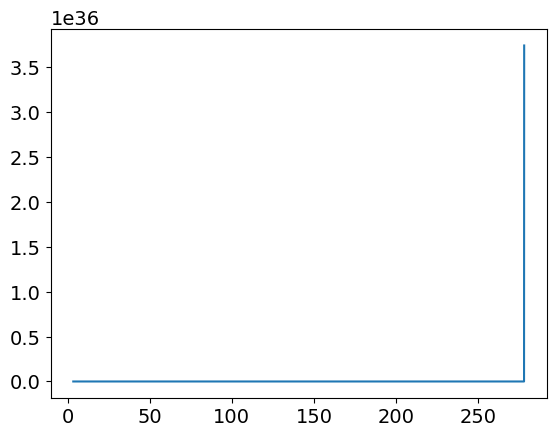

In [583]:
# ELBO
names = ["A0", "r0", "C1+^2", "P1+", "C1-^2", "P1-"]
plt.plot(time_array[50:], -loss_array[50:])
plt.show()

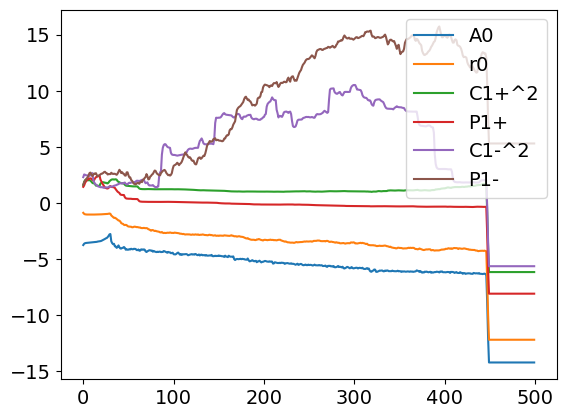

In [579]:
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

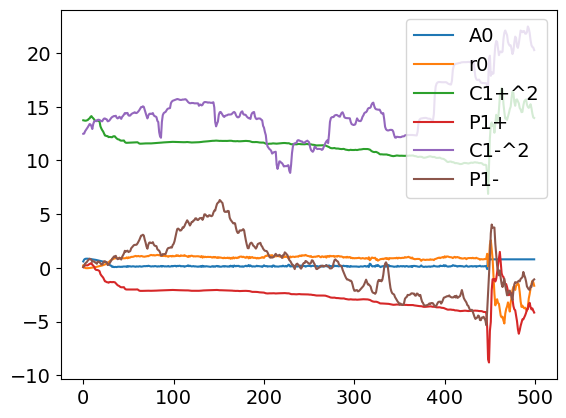

In [580]:
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

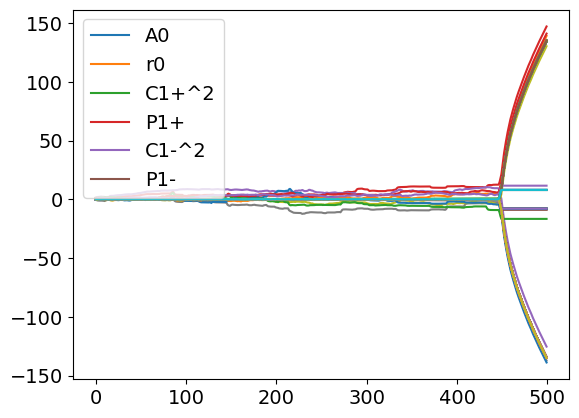

In [581]:
plt.plot(np.array(param_dictionary["q_theta_c"])[:,0,:])
plt.legend(names)
plt.show()

### ELBO optimization - MF

In [482]:
torch.manual_seed(2)

### Data 
x_train = torch.tensor(data_train.theta_cs)
y_train = torch.tensor(data_train.cs_data)

### torch.nn.Module class instance
nMC = 5
param_dim = 6
x_dim = 1
#model = MCElboMF(nMC = nMC, x_dim = x_dim,
#                 param_dim = param_dim,
#                 f_dim = data_train.f_bounds.shape[0],
#                 err_cs = data_train.err_cs,
#                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
#                 which_data = "both", barnard_Elab = data_train.barnard_Elab, l_som = data_train.l_som)

model = MCElboMF(nMC = nMC, x_dim = x_dim,
                 param_dim = param_dim,
                 f_dim = data_train.f_bounds.shape[0],
                 err_cs = data_train.err_cs,
                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
                 which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

learning_rate = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 12000
# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute prediction
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    
    # Utiliti computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime 
    
    if t % 10 == 9: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 100 == 99:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

endTime = time.time()
print(endTime - startTime)

Loss: 19075.865234375, Step [99/12000]
theta mean: Parameter containing:
tensor([[ 0.0885,  0.9711, 13.3907, -0.7307, 12.2225, -0.4281,  0.9894,  0.9433,
          1.1180,  1.1081,  1.1597,  1.1957,  1.2031,  1.3384,  1.4831,  1.2018]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0064, 0.1597, 1.7230, 1.1487, 1.9883, 1.3058, 0.0119, 0.0120, 0.0221,
         0.0195, 0.0213, 0.0179, 0.0279, 0.0225, 0.0441, 0.0421]],
       dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Minutes remaining 5.852163886421859
Loss: 14183.4326171875, Step [199/12000]
theta mean: Parameter containing:
tensor([[ 0.0777,  1.0929, 13.2555, -0.9789, 11.9796, -0.7481,  0.9873,  0.9427,
          1.1297,  1.1248,  1.2065,  1.2439,  1.2564,  1.3869,  1.5504,  1.3003]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0041, 0.1005, 1.6649, 0.9829, 1.9700, 1.0381, 0.0080, 0.0087, 0.0139,
         0.0125, 0.0124, 0.0141, 0.0178, 0.0179, 0.0225, 0.0219]],
       dtype=to

Loss: 12043.2880859375, Step [1499/12000]
theta mean: Parameter containing:
tensor([[ 0.0917,  1.1624, 13.2149, -1.2691, 12.1085, -0.9924,  0.9815,  0.9484,
          1.1289,  1.1275,  1.2085,  1.2613,  1.2678,  1.4280,  1.6075,  1.3551]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.0627e-03, 2.0841e-02, 1.6388e+00, 5.9176e-01, 1.8028e+00, 5.5019e-01,
         5.5550e-03, 3.7782e-03, 3.6314e-03, 3.4002e-03, 3.4001e-03, 4.1587e-03,
         4.2236e-03, 5.0745e-03, 5.9988e-03, 5.5750e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 4.857088377283816
Loss: 12135.12109375, Step [1599/12000]
theta mean: Parameter containing:
tensor([[ 0.0868,  1.1661, 13.2445, -1.2513, 12.1716, -0.9562,  0.9800,  0.9451,
          1.1355,  1.1320,  1.2104,  1.2589,  1.2702,  1.4263,  1.6031,  1.3521]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.0104e-03, 1.9646e-02, 1.6322e+00, 5.7515e-01, 1.7779e+00, 5.3471e-01,
       

Loss: 11818.630859375, Step [2899/12000]
theta mean: Parameter containing:
tensor([[ 0.0896,  1.2201, 13.9510, -0.6886, 13.3769, -0.1467,  0.9772,  0.9461,
          1.1304,  1.1217,  1.1909,  1.2334,  1.2405,  1.3753,  1.5334,  1.2684]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[5.9831e-04, 1.0986e-02, 1.4791e+00, 3.5203e-01, 1.4183e+00, 3.0985e-01,
         5.8148e-03, 3.6615e-03, 2.8532e-03, 2.9490e-03, 2.4846e-03, 2.9453e-03,
         2.8008e-03, 3.2604e-03, 3.7741e-03, 3.4134e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 4.172658348238385
Loss: 11679.3212890625, Step [2999/12000]
theta mean: Parameter containing:
tensor([[ 0.0859,  1.2322, 14.0236, -0.6251, 13.4961, -0.0790,  0.9802,  0.9515,
          1.1332,  1.1180,  1.1862,  1.2312,  1.2317,  1.3660,  1.5240,  1.2570]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[5.7644e-04, 1.0365e-02, 1.4715e+00, 3.3463e-01, 1.3611e+00, 2.9123e-01,
      

Loss: 11266.5830078125, Step [4299/12000]
theta mean: Parameter containing:
tensor([[ 0.0778,  1.3136, 15.3459,  0.3598, 14.9398,  0.5237,  0.9777,  0.9424,
          1.1234,  1.0930,  1.1517,  1.1728,  1.1756,  1.2664,  1.3866,  1.1114]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[3.4486e-04, 6.1377e-03, 1.1711e+00, 1.5329e-01, 1.1533e+00, 1.2880e-01,
         5.1446e-03, 3.9183e-03, 2.9865e-03, 2.9777e-03, 2.3265e-03, 2.5205e-03,
         2.1111e-03, 2.6988e-03, 3.0991e-03, 2.6996e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 3.482136753734585
Loss: 11350.9638671875, Step [4399/12000]
theta mean: Parameter containing:
tensor([[ 0.0741,  1.3164, 15.4392,  0.3732, 15.0278,  0.5096,  0.9791,  0.9397,
          1.1265,  1.1056,  1.1554,  1.1704,  1.1820,  1.2587,  1.3747,  1.1141]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[3.2636e-04, 5.9244e-03, 1.1515e+00, 1.4187e-01, 1.1469e+00, 1.2252e-01,
     

Loss: 11221.9453125, Step [5699/12000]
theta mean: Parameter containing:
tensor([[ 0.0725,  1.3243, 16.9377,  0.6045, 16.1502,  0.3823,  0.9823,  0.9402,
          1.1251,  1.0990,  1.1435,  1.1696,  1.1739,  1.2474,  1.3620,  1.0873]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[2.5405e-04, 3.9262e-03, 9.0344e-01, 6.9608e-02, 1.0551e+00, 7.6855e-02,
         5.4147e-03, 3.3310e-03, 2.7612e-03, 2.8952e-03, 2.0380e-03, 2.2581e-03,
         2.2671e-03, 2.4519e-03, 2.7624e-03, 2.5061e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 2.8652183814188774
Loss: 11197.044921875, Step [5799/12000]
theta mean: Parameter containing:
tensor([[ 0.0745,  1.3141, 17.0300,  0.5559, 16.1893,  0.3162,  0.9853,  0.9385,
          1.1258,  1.0980,  1.1558,  1.1729,  1.1826,  1.2726,  1.3837,  1.1043]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[2.4591e-04, 3.7977e-03, 8.9249e-01, 6.6849e-02, 1.0658e+00, 7.4503e-02,
        

Loss: 11181.0712890625, Step [7099/12000]
theta mean: Parameter containing:
tensor([[ 0.0723,  1.3209, 18.4842,  0.6062, 16.8130,  0.2932,  0.9737,  0.9354,
          1.1209,  1.1001,  1.1485,  1.1666,  1.1746,  1.2474,  1.3656,  1.0904]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.7592e-04, 2.7707e-03, 8.1208e-01, 4.1227e-02, 1.1916e+00, 5.4571e-02,
         4.5573e-03, 3.6163e-03, 3.1106e-03, 2.5532e-03, 2.3162e-03, 2.6047e-03,
         2.0175e-03, 2.9775e-03, 3.3243e-03, 2.6905e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 2.2259329952605706
Loss: 11207.181640625, Step [7199/12000]
theta mean: Parameter containing:
tensor([[ 0.0728,  1.3252, 18.6021,  0.6557, 16.8799,  0.3322,  0.9754,  0.9327,
          1.1168,  1.0948,  1.1490,  1.1622,  1.1709,  1.2428,  1.3507,  1.0817]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.8109e-04, 2.6985e-03, 8.2117e-01, 4.0061e-02, 1.1534e+00, 5.3430e-02,
     

Loss: 11186.57421875, Step [8499/12000]
theta mean: Parameter containing:
tensor([[ 0.0714,  1.3249, 19.5206,  0.6693, 17.1117,  0.3203,  0.9746,  0.9385,
          1.1162,  1.0902,  1.1482,  1.1585,  1.1665,  1.2425,  1.3577,  1.0853]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.8977e-04, 2.2027e-03, 8.7089e-01, 2.7026e-02, 1.2193e+00, 4.0400e-02,
         5.9760e-03, 3.1886e-03, 3.0004e-03, 2.8412e-03, 2.2273e-03, 2.3625e-03,
         2.1244e-03, 2.4508e-03, 2.8298e-03, 2.6720e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 1.5834000047634231
Loss: 11178.427734375, Step [8599/12000]
theta mean: Parameter containing:
tensor([[ 0.0719,  1.3233, 19.5515,  0.6666, 17.1167,  0.3203,  0.9832,  0.9454,
          1.1248,  1.0972,  1.1513,  1.1655,  1.1689,  1.2501,  1.3606,  1.0822]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.8176e-04, 2.2040e-03, 8.6559e-01, 2.6231e-02, 1.1983e+00, 3.9527e-02,
       

Loss: 11353.1259765625, Step [9899/12000]
theta mean: Parameter containing:
tensor([[ 0.0717,  1.3217, 19.6867,  0.6175, 17.0615,  0.2624,  0.9695,  0.9397,
          1.1217,  1.0988,  1.1434,  1.1637,  1.1742,  1.2504,  1.3611,  1.0907]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.5500e-04, 1.9036e-03, 8.5245e-01, 1.9036e-02, 1.2431e+00, 3.1574e-02,
         5.7943e-03, 4.5838e-03, 2.9232e-03, 2.6131e-03, 2.6061e-03, 2.3335e-03,
         2.3521e-03, 2.7490e-03, 2.1622e-03, 3.3648e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 0.9479811224619676
Loss: 11238.1875, Step [9999/12000]
theta mean: Parameter containing:
tensor([[ 0.0727,  1.3231, 19.7092,  0.6570, 17.0966,  0.2986,  0.9802,  0.9440,
          1.1233,  1.0979,  1.1456,  1.1564,  1.1658,  1.2415,  1.3451,  1.0750]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.7538e-04, 1.8570e-03, 9.0001e-01, 1.8576e-02, 1.2223e+00, 3.1001e-02,
         5

Loss: 11240.69921875, Step [11299/12000]
theta mean: Parameter containing:
tensor([[ 0.0746,  1.3215, 19.7503,  0.6636, 17.0464,  0.3012,  0.9794,  0.9375,
          1.1189,  1.0993,  1.1484,  1.1600,  1.1656,  1.2396,  1.3519,  1.0781]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.8841e-04, 2.1500e-03, 8.9377e-01, 1.4342e-02, 1.2946e+00, 2.6994e-02,
         5.2826e-03, 4.0820e-03, 3.2560e-03, 2.4440e-03, 2.1053e-03, 2.4183e-03,
         2.1073e-03, 2.4434e-03, 2.8761e-03, 2.8836e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 0.3190224364816212
Loss: 11515.2890625, Step [11399/12000]
theta mean: Parameter containing:
tensor([[ 0.0704,  1.3268, 19.7375,  0.6539, 17.0844,  0.2955,  0.9716,  0.9391,
          1.1299,  1.0960,  1.1464,  1.1666,  1.1728,  1.2482,  1.3574,  1.0871]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[2.0396e-04, 2.2177e-03, 9.4298e-01, 1.4057e-02, 1.1556e+00, 2.6901e-02,
       

## Save results

In [487]:
folder = "Outputs"
run_id = "som_1"

if not os.path.exists(folder):
    os.makedirs(folder)

dictionary_outputs = copy.deepcopy(param_dictionary)
dictionary_outputs["ELBO"] = -loss_array
dictionary_outputs["time"] = time_array
with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'wb') as handle:
    pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Print variational posteriors and ELBO

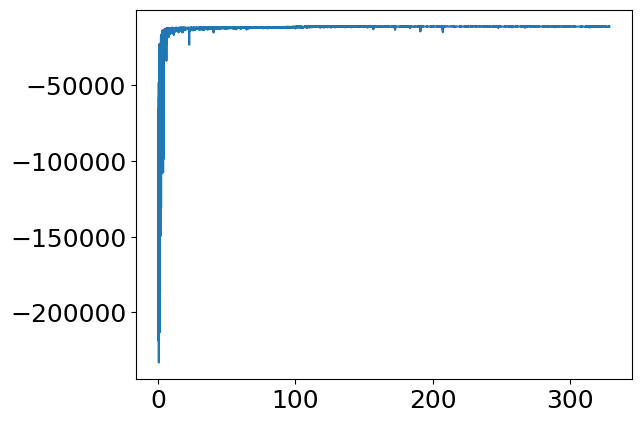

In [488]:
# ELBO
names = ["A0", "r0", "C1+^2", "P1+", "C1-^2", "P1-"]
plt.plot(time_array[10:], -loss_array[10:])
plt.show()

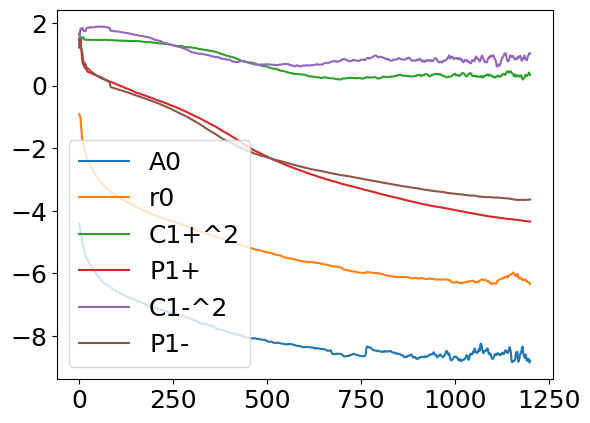

In [489]:
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

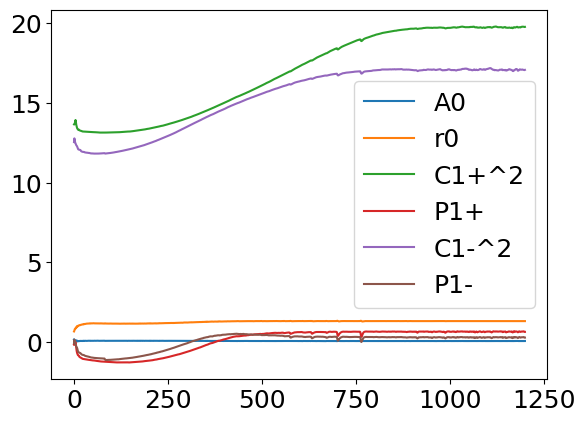

In [490]:
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

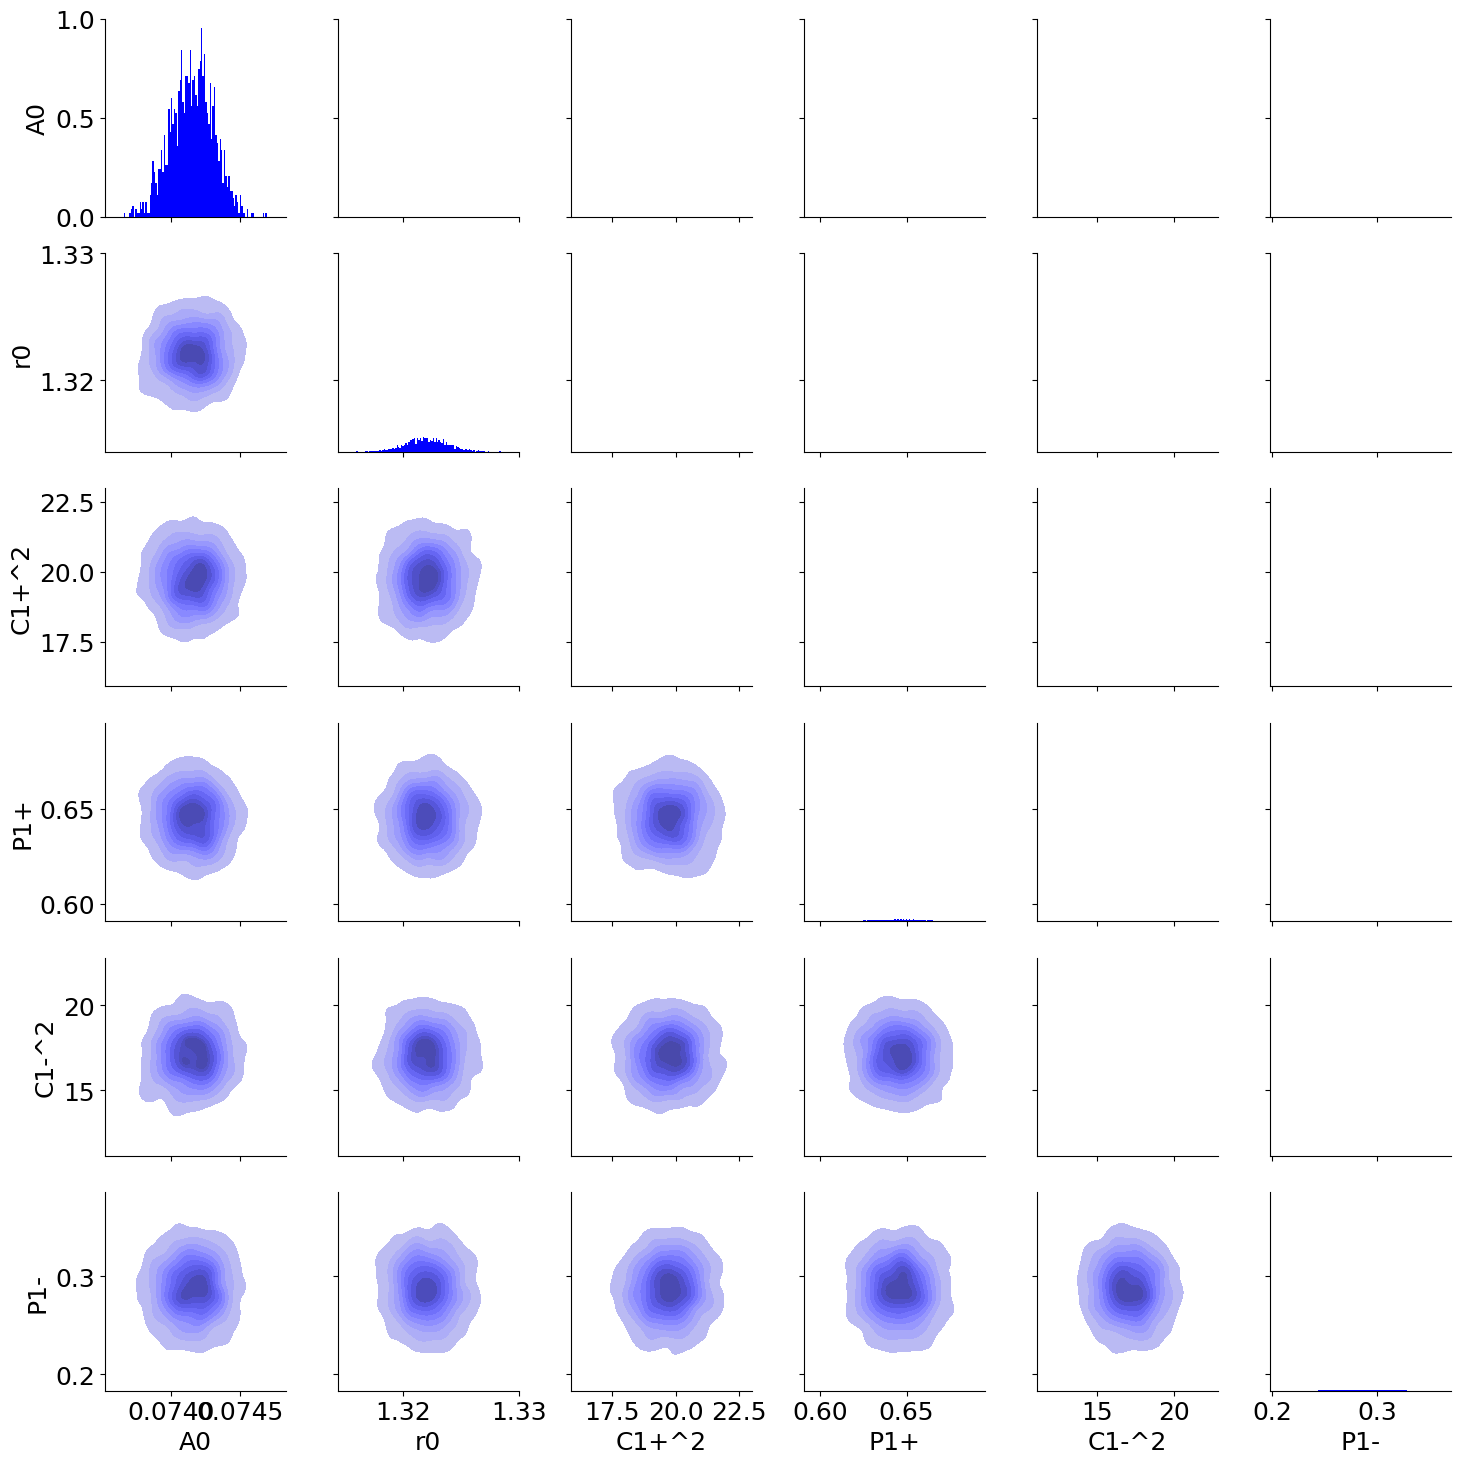

In [491]:
# VI Psoteriors
model.nMC = 1500
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, model.q_theta_s)

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
g = sns.PairGrid(samples)
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
plt.show()

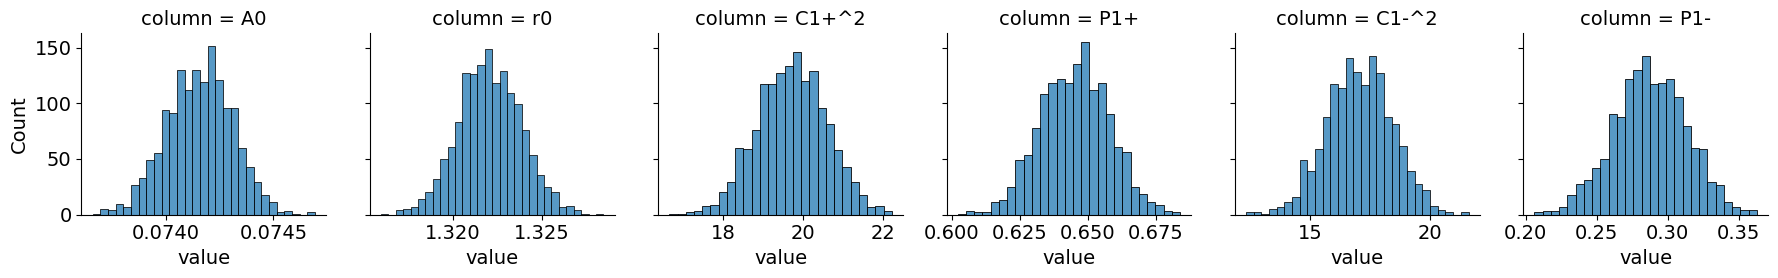

In [502]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(sns.histplot, 'value')
plt.show()

<AxesSubplot:>

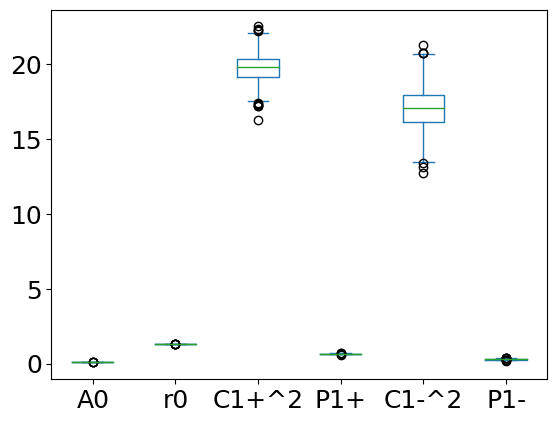

In [419]:
samples.plot(kind = "box")

# Extra (trying some code)

Cholesky parametrization of the full gaussian variation family, will require $n_{param} * (n_{param} + 1) / 2$ variational parameters for the covariance structure and $n_{param}$ for the mean. That is $n_{param} * (n_{param} + 3)/2$ overall. Ex. for $n_{param} = 10$, we get 65 variational parameters.

In [42]:
S = torch.tensor([[2,0,0.5],[0,1,-0.5], [0.5,-0.5,3]])
print(f'Covariance matrix \n {S}')
L = torch.linalg.cholesky(S)
print(f'Cholesky lower triang factor\n  {L}')
print(f'Reconstructed matrix\n  {L @ L.T}')

Covariance matrix 
 tensor([[ 2.0000,  0.0000,  0.5000],
        [ 0.0000,  1.0000, -0.5000],
        [ 0.5000, -0.5000,  3.0000]])
Cholesky lower triang factor
  tensor([[ 1.4142,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000],
        [ 0.3536, -0.5000,  1.6202]])
Reconstructed matrix
  tensor([[ 2.0000,  0.0000,  0.5000],
        [ 0.0000,  1.0000, -0.5000],
        [ 0.5000, -0.5000,  3.0000]])


In [59]:
# Vector to triangular matrix
S = torch.zeros((10,10))
up_i = np.triu_indices(10)
S[up_i] = torch.randn(5 *11)
print(f'Lower triangular matrix from a 1D tensor \n {S.T}')

Lower triangular matrix from a 1D tensor 
 tensor([[-0.1895,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.8098,  0.3005,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.5035, -0.0109,  0.6915,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.8682,  1.0818, -0.7839,  0.1688,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.7227, -0.5616, -0.2791, -0.1750, -0.4001,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.3620, -1.7821,  1.7892,  0.7355,  1.6257,  1.0882,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.6500,  0.2946,  0.0154, -1.2928, -1.4400, -1.3694, -0.3584,  0.0000,
          0.0000,  0.0000],
        [-0.4551,  0.7210, -0.3492, -0.0394,  0.5699, -1.3395, -0.2353,  0.1916,
          0.0000,  0.0000],
        [ 1.3262, -0.0361,  0.1846, -0.4034,  0.1264, -0.9801, -1.1188,  1.2491,
    

In [67]:
# With offset for the diagonal terms which need to be positive
# Vector to triangular matrix
S = torch.zeros((10,10))
up_i = np.triu_indices(10, k =1)
S[up_i] = torch.randn(5 *11 - 10) # Off-diagonal
S[(np.array(range(10)),np.array(range(10)))] = 1 # Diagonal
print(f'Lower triangular matrix from a 1D tensor \n {S.T}')

Lower triangular matrix from a 1D tensor 
 tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-6.1234e-01,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 7.5384e-01,  1.9672e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 4.9106e-04,  7.6106e-01,  6.3320e-01,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-8.7311e-01,  7.8366e-01, -8.7206e-02, -7.2882e-01,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.4723e+00, -5.4691e-01,  1.3925e+00,  9.8476e-02, -1.8922e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 6.7157e-01, -7.8314e-02,  8.7555e-01,  1.0496e+00,  6